In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from pyro.infer import Predictive
import torch
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from tqdm.autonotebook import tqdm
from IPython.display import clear_output
import os

In [2]:
from typing import List, Tuple
from numpy.typing import ArrayLike
from pandas import DataFrame

Helper functions to create windowd dataset with lad and/or lead features

In [3]:
def split(data,ToRemove,target,features_to_use,perc=0.8,clean=False):
    features = [c for c in data.columns if not (c in ToRemove or c in target)]
    features = features_to_use
    if clean==True:
        return data[features],data[target]
    
    machines = pd.read_csv('../data/raw2/PdM_machines.csv')
    x_train_,x_test_,y_train_,y_test_,train_idx,test_idx = train_test_split(machines, machines.model, machines.machineID.index, test_size=0.2, stratify=machines.model, random_state=42)
    
    print(y_test_.value_counts())
    print(y_train_.value_counts())
    print(machines.model.value_counts())

    training=data[data['machineID'].isin(train_idx)]
    test=data[data['machineID'].isin(test_idx)]
    x_train=training[features]
    y_train=training[target]
    x_test=test[features]
    y_test=test[target]
    
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
    return x_train,y_train,x_test,y_test

In [4]:
def get_lag_columns(columns: List[str], lag_steps: int) -> List[str]:
    """
    Returns the new title columns, by adding the lag number
    Includes the initial column names in the end.
    """
    new_columns = []
    for i in range(lag_steps, 0, -1):
        new_columns += [col_title + f"-{i}" for col_title in columns]

    new_columns += columns
    return new_columns


def get_lead_columns(columns: List[str], lead_steps: int) -> List[str]:
    """
    Returns the new title columns, by adding the lead number
    Includes the initial column names in the beginning.
    """
    new_columns = []
    new_columns += columns
    for i in range(1, lead_steps + 1):
        new_columns += [col_title + f"+{i}" for col_title in columns]

    return new_columns

In [5]:
def windowed_df_lag(df: DataFrame, columns_to_lag: List[str], lag_steps: int):
    temp_df = df[columns_to_lag]

    for i in range(1, lag_steps + 1):
        tmp = df[columns_to_lag].shift(i)
        temp_df = pd.concat([tmp, temp_df], axis=1)

    temp_df.columns = get_lag_columns(columns_to_lag, lag_steps)

    return temp_df.iloc[lag_steps:, :]


def windowed_df_lead(
    df: DataFrame, columns_to_lead: List[str], lead_steps: int
) -> DataFrame:
    temp_df = df[columns_to_lead]

    for i in range(1, lead_steps + 1):
        tmp = df[columns_to_lead].shift(-i)
        temp_df = pd.concat([tmp, temp_df], axis=1)

    temp_df.columns = get_lead_columns(columns_to_lead, lead_steps)

    return temp_df.iloc[:-lead_steps, :]




In [6]:
def create_windowed_df_per_machine(
    df: DataFrame,
    columns_to_lag: List[str],
    columns_to_lead: List[str],
    lag_steps: int,
    lead_steps: int,
) -> Tuple[DataFrame, ArrayLike]:
    if lag_steps == 0:
        lag_df = df[columns_to_lag]
    else:
        lag_df = windowed_df_lag(df, columns_to_lag, lag_steps)

    if lead_steps == 0:
        lead_df = df[columns_to_lead]
    else:
        lead_df = windowed_df_lead(df, columns_to_lead, lead_steps)

    if lead_steps > 0:
        lag_df = lag_df.iloc[:-lead_steps, :]

    if lag_steps > 0:
        lead_df = lead_df.iloc[lag_steps:, :]

    final_df = pd.concat([lag_df, lead_df], axis=1)

    return final_df, final_df.index.to_numpy()


def create_windowed_df(
    df: DataFrame,
    id_col: str,
    columns_to_lag: List[str],
    columns_to_lead: List[str],
    lag_steps: int,
    lead_steps: int,
) -> Tuple[DataFrame, ArrayLike]:
    """
    Return telemetry data per id_col
    """

    unique_ids = df[id_col].unique()

    for i, id_ in enumerate(unique_ids):
        df_id = df.loc[df[id_col] == id_]

        df_id = df_id.reset_index(drop=True)

        telemetry_df, idx = create_windowed_df_per_machine(
            df_id, columns_to_lag, columns_to_lead, lag_steps, lead_steps
        )

        # Drop all columns used for telemetry lead and lag
        df_rest = df_id.drop(columns_to_lag + columns_to_lead, axis=1)

        df_rest = df_rest.iloc[idx, :]

        # Combine the reduced column with the lead-lagged telemtry dataframe
        tmp_df = pd.concat([df_rest, telemetry_df], axis=1)

        # Stack for each machine the recreated dataframe.
        # If it is the fist time the loop runs, create the new dataframe with the first recreated df
        if i == 0:
            final_df = tmp_df.copy()
        else:
            final_df = pd.concat([final_df, tmp_df], axis=0)

    final_df.reset_index(inplace=True, drop=True)
    return final_df

Load the processed dataset

In [7]:
data = pd.read_csv(os.path.join('..', 'data','processed','data_processed.csv'))

In [8]:
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [9]:
data.datetime = pd.to_datetime(data.datetime, format="%Y-%m-%d %H:%M:%S")

In [10]:
data.columns

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

Test linear regression algorithm for `machineID` = 1 and for target `y=comp1_life`.

In [11]:
TELEMETRY_COLUMNS = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h']
target = ["comp1_life"]

tst_df = create_windowed_df(data, "machineID", TELEMETRY_COLUMNS, target, 0, 0)

In [12]:
tst_df.columns

Index(['machineID', 'datetime', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'comp1', 'comp2', 'comp3', 'comp4',
       'comp2_life', 'comp3_life', 'comp4_life', 'age', 'model_model1',
       'model_model2', 'model_model3', 'model_model4', 'failure', 'comp1_fail',
       'comp2_fail', 'comp3_fail', 'comp4_fail', 'voltmean_3h',
       'rotatemean_3h', 'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h',
       'rotatesd_3h', 'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h',
       'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h',
       'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'comp1_life'],
      dtype='object')

In [13]:
# data_1 = tst_df.loc[data.machineID==1]
data_1 = tst_df.copy()

In [14]:
# list(data_1.columns)[24:-1]

In [15]:
feat_cols = ['comp1', 'comp2', 'comp3',
       'comp4''voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4']

feat_cols = ['error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4']

wind_used_cols = list(data_1.columns)[24:-1]

feat_cols = feat_cols + wind_used_cols

target = ['comp1_life']

In [16]:
data_1_red = data_1[feat_cols+target]


In [17]:
data_1_red.shape

(290642, 27)

In [18]:
data_1_red.dropna(inplace=True)

/tmp/ipykernel_8625/3848255571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_red.dropna(inplace=True)


In [19]:
X = data_1_red[feat_cols].values
y = data_1_red[target].values

n, p = X.shape

Split to train and test data. Use the split from John afterwards

In [20]:
train_ratio = 0.8
train_idx = int(train_ratio*n)
X_train = X[:train_idx]
X_test = X[train_idx:]

y_train = y[:train_idx].flatten()
y_test = y[train_idx:].flatten()

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (207827, 26), X_test shape: (51957, 26)
y_train shape: (207827,), y_test shape: (51957,)


Standardize the datasets

In [21]:
init_els_non_std = 0

X_mean = X_train[:, init_els_non_std:].mean(axis=0)
X_std = X_train[:,init_els_non_std:].std(axis=0)

y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)

In [22]:
X_train_n = X_train.copy()
X_train_n[:,:] = (X_train[:,init_els_non_std:]-X_mean)/X_std

X_test_n = X_test.copy()
X_test_n[:,init_els_non_std:] = (X_test[:,init_els_non_std:]-X_mean)/X_std

y_train_n = (y_train-y_mean)/y_std
y_test_n = (y_test-y_mean)/y_std

In [23]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train_n).float()
y_train_torch = torch.tensor(y_train_n).float()

print(f"X_train shape: {X_train_n.shape}")
print(f"y_train shape: {y_train_n.shape}")

X_train shape: (207827, 26)
y_train shape: (207827,)


In [24]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [25]:
def model(X, obs=None):
    
    lmbd = 5
    
    alpha = pyro.sample("alpha", dist.Normal(0., lmbd*1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            lmbd*torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [26]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [27]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [28]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 807037.8
[100] ELBO: 556234.0
[200] ELBO: 404254.7
[300] ELBO: 302419.1
[400] ELBO: 296368.3
[500] ELBO: 294867.2
[600] ELBO: 294871.3
[700] ELBO: 294578.4
[800] ELBO: 294456.1
[900] ELBO: 294536.2
[1000] ELBO: 294465.5
[1100] ELBO: 294453.7
[1200] ELBO: 294443.5
[1300] ELBO: 294443.2
[1400] ELBO: 294450.2
[1500] ELBO: 294463.5
[1600] ELBO: 294449.6
[1700] ELBO: 294459.0
[1800] ELBO: 294455.8
[1900] ELBO: 294476.8
[2000] ELBO: 294441.4
[2100] ELBO: 294441.3
[2200] ELBO: 294458.2
[2300] ELBO: 294448.5
[2400] ELBO: 294458.2
[2500] ELBO: 294468.3
[2600] ELBO: 294440.4
[2700] ELBO: 294449.4
[2800] ELBO: 294465.0
[2900] ELBO: 294458.2
[3000] ELBO: 294460.4
[3100] ELBO: 294420.6
[3200] ELBO: 294453.5
[3300] ELBO: 294455.7
[3400] ELBO: 294455.0
[3500] ELBO: 294421.4
[3600] ELBO: 294453.8
[3700] ELBO: 294448.2
[3800] ELBO: 294432.2
[3900] ELBO: 294442.1
[4000] ELBO: 294446.2
[4100] ELBO: 294465.1
[4200] ELBO: 294452.8
[4300] ELBO: 294448.2
[4400] ELBO: 294441.2
[4500] ELBO: 294433.2


In [29]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [30]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test_n, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test_n * y_std + y_mean

# Training error
y_hat_train = np.mean(alpha_samples.T + np.dot(X_train_n, beta_samples[:,0].T), axis=1)

preds_train = y_hat_train * y_std + y_mean
y_true_train = y_train_n * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.101
MAE: 24.671
RMSE: 30.027
R2: 0.000


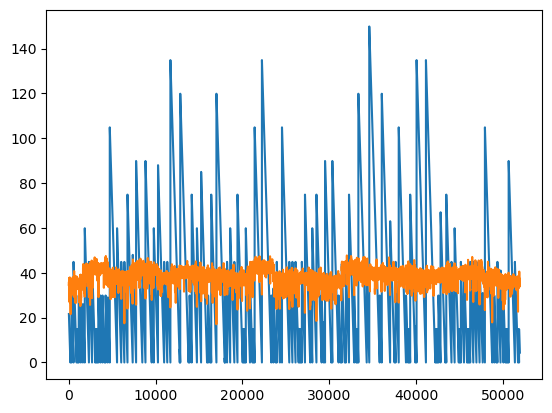

In [31]:
plt.plot(y_true)
plt.plot(preds)

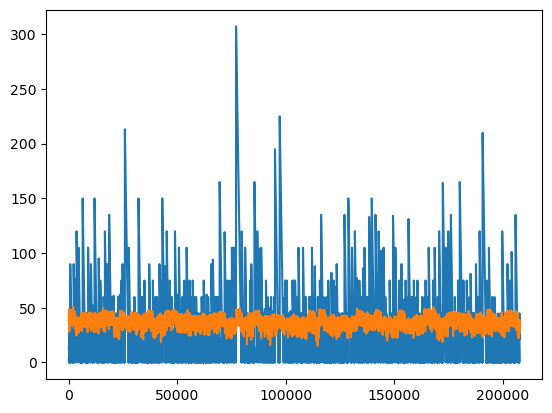

In [32]:
plt.plot(y_true_train)
plt.plot(preds_train)

In [33]:
from sklearn import linear_model

regr = linear_model.Ridge(fit_intercept=True, alpha=50000)
regr.fit(X_train_n, y_train_n)
preds_lr = regr.predict(X_test_n)

mae = np.mean(np.abs(y_test_n-preds_lr))
print("MAE:", mae)

MAE: 0.6503008241057836


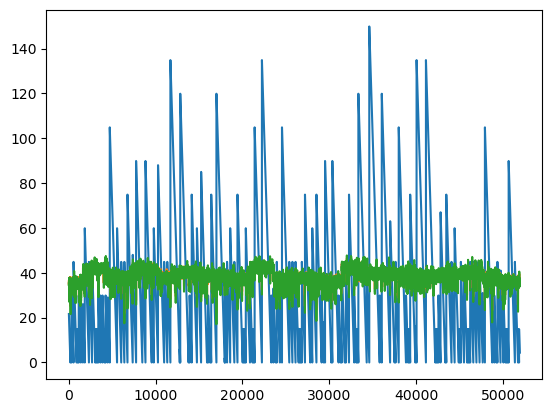

In [34]:
plt.plot(y_test)
plt.plot(preds_lr*y_std+y_mean)
plt.plot(preds)

Bad results. Try with FNN:

In [35]:
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

In [36]:

class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        
        n_hidden_2 = 100        
        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden_2)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden_2, n_hidden]).to_event(2))
        
        n_hidden_3 = 25        
        self.h_layer3 = PyroModule[nn.Linear](n_hidden_2, n_hidden_3)
        self.h_layer3.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden_3, n_hidden_2]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden_3, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden_3]).to_event(2))
        
#         if not (type(n_hidden) is list):
#             n_hidden = [n_hidden]
            
#         self.in_layer = PyroModule[nn.Linear](n_in, n_hidden[0])
#         self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden[0], n_in]).to_event(2))
        
#         self.hidden_layers = []
#         for i in range(1,len(n_hidden)):
#             print(i)
#             tmp_h_layer = PyroModule[nn.Linear](n_hidden[i-1], n_hidden[i])
#             tmp_h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden[i], n_hidden[i-1]]).to_event(2))
#             self.hidden_layers.append(tmp_h_layer)
            
#         self.out_layer = PyroModule[nn.Linear](n_hidden[-1], n_out)
#         self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden[-1]]).to_event(2))
        
        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        X = self.tanh(self.in_layer(X))
        
#         for i in range(len(self.hidden_layers)):
#             X = self.tanh(self.hidden_layers[i](X))
        
        X = self.tanh(self.h_layer(X))
        
        X = self.tanh(self.h_layer2(X))
        
        X = self.tanh(self.h_layer3(X))

        
        X = self.out_layer(X)
        prediction_mean = X.squeeze(-1)
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
            
        return y

In [37]:
# Define guide function
model = FFNN(n_in=X_train.shape[1], n_hidden=40, n_out=1)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 24807588.6
[500] ELBO: 10149876.0
[1000] ELBO: 9719796.3
[1500] ELBO: 9304597.0
[2000] ELBO: 8871811.8
[2500] ELBO: 8357964.6
[3000] ELBO: 7943323.7
[3500] ELBO: 7503858.6
[4000] ELBO: 7164994.4
[4500] ELBO: 6917806.1
[5000] ELBO: 6704801.1
[5500] ELBO: 6538099.4
[6000] ELBO: 6397371.5
[6500] ELBO: 6335480.2
[7000] ELBO: 6293655.5
[7500] ELBO: 6216661.4
[8000] ELBO: 6168064.0
[8500] ELBO: 6123202.2
[9000] ELBO: 6089312.3


In [ ]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test_n).float()

In [ ]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

In [ ]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test_n - y_pred))
print("MAE:", mae)

In [ ]:
plt.plot(y_test)
plt.plot(y_pred*y_std+y_mean)

cv

In [ ]:
lambdas = np.logspace(0,2,5)